# **DataSource Selection**: Data Source and Event Type Analysis
------------------

## Goals:
1. Identify most relevent data sources based on MITRE ATT&ck Techniques
    * Frequency counts based on all TTPs
    * Frequency counts based on common TTPs (only those TTPs attributed to tracked threat groups)
    * Frequency counts based on modern TTPs (only those TTPs identified in 2019/2020 thrend reports)
    * Map Generic MITRE ATT&ck Data sources to Events
2. Conduct Exploratory Data Analysis on APT29 Detection Hackathon Dataset
3. Identify most relevant data sources and features based on Industry Guidance

## References:
* https://github.com/hunters-forge/ATTACK-Python-Client
* https://github.com/OTRF/detection-hackathon-apt29
* https://infosecjupyterthon.com/notebooks/2_Jupyterthon_Cyb3rPandaH_2020.html
* https://github.com/hunters-forge/ThreatHunter-Playbook
* https://github.com/hunters-forge/OSSEM
* https://www.slideshare.net/attackcon2018 MITRE ATT&CKcon 2.0: Prioritizing Data Sources for Minimum Viable Detection; Keith McCammon, Red Canary 
* https://github.com/keithmccammon/python-attack-utils
* https://github.com/SadProcessor/SomeStuff/blob/master/DerbyCon19/ATTCKnowledge.ps1

### 1. Identify most relevent data sources based on MITRE ATT&ck Techniques
------------------
Utilizing approach in https://github.com/hunters-forge/ATTACK-Python-Client/blob/master/notebooks/ATT%26CK_DataSources.ipynb

In [1]:
from attackcti import attack_client
#import altair as alt
#alt.renderers.enable('notebook')
#import itertools
import pandas as pd, numpy as np
from pandas import json_normalize
import matplotlib.pyplot as plt
import requests
from openhunt import ossem, descriptiveStatistics as ds, visualizations as vis
import warnings
warnings.filterwarnings('ignore')

# Import packages
import os
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

from collections import Counter
import json
import yaml

### 1.A. Frequency counts based on all TTPs
------------------
Reference: https://github.com/hunters-forge/ATTACK-Python-Client
* Using attackcti we can generate a dictionary of MITRE ATT&CK techniques and metadata including datasources

In [2]:
lift = attack_client()
all_techniques = lift.get_techniques(stix_format=False)
all_techniques[0]

{'external_references': [{'source_name': 'mitre-attack',
   'external_id': 'T1205.001',
   'url': 'https://attack.mitre.org/techniques/T1205/001'},
  {'url': 'https://www.giac.org/paper/gcih/342/handle-cd00r-invisible-backdoor/103631',
   'description': 'Hartrell, Greg. (2002, August). Get a handle on cd00r: The invisible backdoor. Retrieved October 13, 2018.',
   'source_name': 'Hartrell cd00r 2002'}],
 'kill_chain_phases': [{'kill_chain_name': 'mitre-attack',
   'phase_name': 'defense-evasion'},
  {'kill_chain_name': 'mitre-attack', 'phase_name': 'persistence'},
  {'kill_chain_name': 'mitre-attack', 'phase_name': 'command-and-control'}],
 'x_mitre_version': '1.0',
 'x_mitre_is_subtechnique': True,
 'url': 'https://attack.mitre.org/techniques/T1205/001',
 'matrix': 'mitre-attack',
 'technique_id': 'T1205.001',
 'object_marking_refs': ['marking-definition--fa42a846-8d90-4e51-bc29-71d5b4802168'],
 'created_by_ref': 'identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5',
 'technique': 'Port Kn

In [4]:
all_techniques[0]['data_sources']

['Netflow/Enclave netflow', 'Packet capture']

In [5]:
all_techniques[0].keys()

dict_keys(['external_references', 'kill_chain_phases', 'x_mitre_version', 'x_mitre_is_subtechnique', 'url', 'matrix', 'technique_id', 'object_marking_refs', 'created_by_ref', 'technique', 'technique_description', 'id', 'type', 'tactic', 'modified', 'created', 'permissions_required', 'technique_detection', 'data_sources', 'platform'])

In [13]:
data_sources_dup = list()
for t in all_techniques:
    # ensure technique has datasources assigned and applies to Windows platform
    if 'data_sources' in t.keys() and 'Windows' in t['platform']:
        for ds in t['data_sources']:
                data_sources_dup.append(ds)
        if t['technique'] == 'Command and Scripting Interpreter':
            display(t)
        #print(t['platform'])

{'external_references': [{'source_name': 'mitre-attack',
   'external_id': 'T1059',
   'url': 'https://attack.mitre.org/techniques/T1059'}],
 'kill_chain_phases': [{'kill_chain_name': 'mitre-attack',
   'phase_name': 'execution'}],
 'x_mitre_is_subtechnique': False,
 'x_mitre_version': '2.0',
 'id': 'attack-pattern--7385dfaf-6886-4229-9ecd-6fd678040830',
 'created_by_ref': 'identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5',
 'technique': 'Command and Scripting Interpreter',
 'technique_description': 'Adversaries may abuse command and script interpreters to execute commands, scripts, or binaries. These interfaces and languages provide ways of interacting with computer systems and are a common feature across many different platforms. Most systems come with some built-in command-line interface and scripting capabilities, for example, macOS and Linux distributions include some flavor of [Unix Shell](https://attack.mitre.org/techniques/T1059/004) while Windows installations include the [Windo

In [14]:
len(data_sources_dup)

1391

In [18]:
pd.Series(data_sources_dup).value_counts().head(20)

Process monitoring                    260
Process command-line parameters       163
File monitoring                       134
API monitoring                         70
Packet capture                         67
Process use of network                 61
Netflow/Enclave netflow                58
Windows Registry                       55
Authentication logs                    49
Network protocol analysis              47
Windows event logs                     46
DLL monitoring                         35
SSL/TLS inspection                     24
Binary file metadata                   24
Loaded DLLs                            23
PowerShell logs                        20
Network device logs                    15
Network intrusion detection system     15
Azure activity logs                    13
AWS CloudTrail logs                    13
dtype: int64

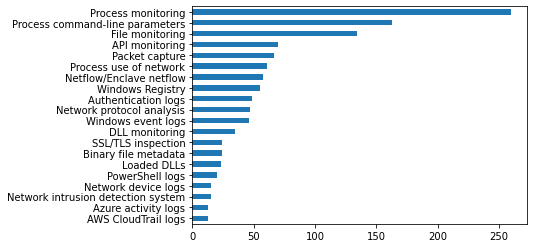

In [19]:
pd.Series(data_sources_dup).value_counts(ascending=True).tail(20).plot(kind='barh')

### 1.B. Frequency counts based on common TTPs (only those TTPs attributed to tracked threat groups)
------------------
Reference: https://github.com/rabobank-cdc/DeTTECT/wiki/Threat-actor-group-mapping
* Using Mitre DeTTECT we can generate a json file with all threat actor data within ATT&CK
* python dettect.py g -> attack_windows_all.json
* This provides us with a subset of techniques attributed to known threat actors.

In [24]:
with open('/home/jake/Documents/output/attack_windows_all.json') as json_file:
    attack_windows_all = json.load(json_file)

In [25]:
#attack_windows_all['techniques']
#for p in attack_windows_all['techniques']:
#    print(p['techniqueID'], p['score'])
    
attack_windows_all_techniques = set()
for p in attack_windows_all['techniques']:
    attack_windows_all_techniques.add(p['techniqueID'])

In [26]:
len(attack_windows_all_techniques)

168

In [27]:
data_sources_dup_attack = list()
for t in all_techniques:
    # ensure technique has datasources assigned and applies to Windows platform
    if 'data_sources' in t.keys() and 'Windows' in t['platform'] and t['technique_id'] in attack_windows_all_techniques:
        for ds in t['data_sources']:
                data_sources_dup_attack.append(ds)
        #print(t['technique_id'])

In [28]:
len(data_sources_dup_attack)

426

In [29]:
pd.Series(data_sources_dup_attack).value_counts().head(20)

Process monitoring                    80
Process command-line parameters       50
File monitoring                       39
Process use of network                29
Packet capture                        21
API monitoring                        20
Network protocol analysis             17
Netflow/Enclave netflow               16
Windows event logs                    14
Authentication logs                   14
Windows Registry                      10
Azure activity logs                   10
AWS CloudTrail logs                    9
Stackdriver logs                       8
Binary file metadata                   7
PowerShell logs                        6
DLL monitoring                         6
Network intrusion detection system     5
Network device logs                    5
Office 365 account logs                5
dtype: int64

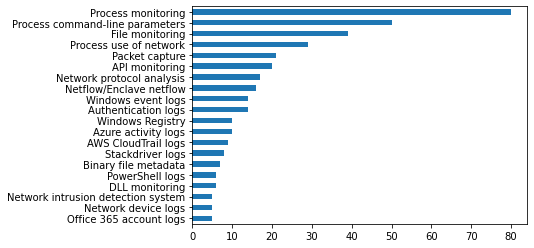

In [30]:
pd.Series(data_sources_dup_attack).value_counts(ascending=True).tail(20).plot(kind='barh')

### 1.C. Frequency counts based on modern TTPs (only those TTPs identified in 2019/2020 thrend reports)
------------------
Reference: https://github.com/rabobank-cdc/DeTTECT/wiki/Threat-actor-group-mapping
* Using Mitre DeTTECT we can utilize their yaml files for modern threat reports.

In [31]:
#!wget https://raw.githubusercontent.com/rabobank-cdc/DeTTECT/master/threat-actor-data/20200220-FireEye.yaml

In [32]:
fireeye_techniques = {'T1040': 1, 'T1201': 1, 'T1007': 1, 'T1124': 1, 'T1480': 1, 'T1158': 1, 'T1093': 1, 'T1031': 1, 'T1023': 1, 'T1081': 1, 'T1214': 1, 'T1111': 1, 'T1491': 1, 'T1173': 1, 'T1106': 1, 'T1170': 1, 'T1179': 1, 'T1049': 1, 'T1497': 1, 'T1036': 1, 'T1117': 1, 'T1096': 1, 'T1482': 1, 'T1135': 1, 'T1140': 1, 'T1168': 1, 'T1077': 1, 'T1490': 1, 'T1492': 1, 'T1014': 2, 'T1094': 2, 'T1047': 2, 'T1138': 2, 'T1055': 2, 'T1058': 2, 'T1188': 2, 'T1219': 2, 'T1021': 2, 'T1496': 2, 'T1083': 3, 'T1046': 3, 'T1057': 3, 'T1016': 3, 'T1054': 3, 'T1004': 3, 'T1015': 3, 'T1087': 4, 'T1069': 4, 'T1034': 4, 'T1012': 4, 'T1038': 4, 'T1073': 4, 'T1099': 4, 'T1102': 4, 'T1022': 4, 'T1192': 4, 'T1136': 5, 'T1486': 5, 'T1033': 5, 'T1116': 5, 'T1090': 5, 'T1070': 5, 'T1060': 5, 'T1110': 5, 'T1193': 5, 'T1082': 6, 'T1089': 6, 'T1112': 7, 'T1063': 7, 'T1199': 7, 'T1059': 8, 'T1489': 8, 'T1045': 9, 'T1003': 9, 'T1071': 10, 'T1098': 10, 'T1107': 11, 'T1105': 11, 'T1053': 11, 'T1078': 11, 'T1202': 13, 'T1002': 13, 'T1032': 14, 'T1100': 16, 'T1190': 17, 'T1076': 19, 'T1133': 28, 'T1035': 28, 'T1086': 29, 'T1064': 30, 'T1027': 31}

In [33]:
set_fireeye_techniques = set(fireeye_techniques)

In [34]:
len(set_fireeye_techniques)

91

In [35]:
data_sources_dup_fireeye = list()
for t in all_techniques:
    # ensure technique has datasources assigned and applies to Windows platform
    if 'data_sources' in t.keys() and 'Windows' in t['platform'] and t['technique_id'] in set_fireeye_techniques:
        for ds in t['data_sources']:
                data_sources_dup_fireeye.append(ds)
        #print(t['technique_id'])

In [36]:
len(data_sources_dup_fireeye)

220

In [38]:
pd.Series(data_sources_dup_fireeye).value_counts().head(20)

Process monitoring                 43
Process command-line parameters    33
File monitoring                    15
API monitoring                     12
Windows event logs                 10
Network protocol analysis           9
Process use of network              9
Packet capture                      9
Authentication logs                 8
Netflow/Enclave netflow             8
Azure activity logs                 7
AWS CloudTrail logs                 6
Windows Registry                    5
Stackdriver logs                    5
Office 365 account logs             4
PowerShell logs                     4
SSL/TLS inspection                  3
Host network interface              2
Web logs                            2
Binary file metadata                2
dtype: int64

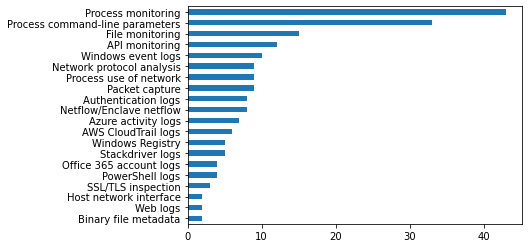

In [39]:
pd.Series(data_sources_dup_fireeye).value_counts(ascending=True).tail(20).plot(kind='barh')

### 1.D. Map Generic MITRE ATT&ck Data sources to Events
------------------
* References: 
    * https://github.com/hunters-forge/OSSEM/tree/master/attack_data_sources
    * https://docs.google.com/spreadsheets/d/1ow7YRDEDJs67kcKMZZ66_5z1ipJry9QrsDQkjQvizJM/edit#gid=0
* Goals:
    * Using hunters-forge/OSSEM identify the events that contribute to MITRE's data sources.

In [24]:
#!wget --no-check-certificate 'https://docs.google.com/spreadsheets/d/1ow7YRDEDJs67kcKMZZ66_5z1ipJry9QrsDQkjQvizJM/export?format=xlsx&id=1ow7YRDEDJs67kcKMZZ66_5z1ipJry9QrsDQkjQvizJM' -O Attack_Data_Modeling.xlsx

In [25]:
attack_data_model = pd.read_excel(open('Attack_Data_Modeling.xlsx', 'rb'), sheet_name='Winevent Logs - ATT&CK')  

In [26]:
attack_data_model.loc[attack_data_model['Data Source'] == 'Process monitoring']

,Data Source,Sub - Data Source,Data Object,Relationship,Data Object.1,Event ID,Description,Provider Name,Event Channel,Data Category,Data Sub-Category,Minimun Operating System,GPO,Enable Commands,Client Default,Server Default
16,Process monitoring,process creation,process,created,process,4688,A new process has been created,Microsoft-Windows-Security-Auditing,Security,Audit Detailed Tracking,Audit Process Creation,"Windows Vista, Windows 2008",Computer Configuration -> Windows Settings -> ...,"auditpol.exe /set /subcategory:""Process Creati...",No auditing,No auditing
17,Process monitoring,process creation,process,created,process,1,Process creation,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Creation,NaN,"Windows 7, Windows 2008 R2",N/A,Sysmon64.exe -i /Sysmon64.exe -i -l /Sysmon64....,No auditing,No auditing
18,Process monitoring,process termination,user,terminated,process,4689,A process has exited,Microsoft-Windows-Security-Auditing,Security,Audit Detailed Tracking,Audit Process Termination,"Windows Vista, Windows 2008",Computer Configuration -> Windows Settings -> ...,"auditpol.exe /set /subcategory:""Process Termin...",No auditing,No auditing
19,Process monitoring,process termination,process,terminated,NaN,5,The process terminate event reports when a pro...,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Terminiation,NaN,"Windows 7, Windows 2008 R2",N/A,Sysmon64.exe -i /Sysmon64.exe -i -l / Sysmon64...,No auditing,No auditing
20,Process monitoring,process write to process,process,wrote_to,process,8,The CreateRemoteThread event detects when a pr...,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Right to Process,CreateRemoteThread,"Windows 7, Windows 2008 R2",N/A,"<CreateRemoteThread onmatch=""exclude"" />",No auditing,No auditing
21,Process monitoring,process access,process,opened,process,10,The process accessed event reports when a proc...,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Access,Process Opens Another Process,"Windows 7, Windows 2008 R2",N/A,"<ProcessAccess onmatch=""exclude"" />",No auditing,No auditing


In [27]:
ossem.getEventDf(platform = 'windows', provider = 'sysmon', event = 'event-1')

,event_code,title,standard_name,standard_type,name,type,description,sample_value
0,1,Event ID 1: Process creation,tag,TBD,RuleName,string,custom tag mapped to event. i.e ATT&CK techniq...,T1114
1,1,Event ID 1: Process creation,event_date_creation,TBD,UtcTime,date,Time in UTC when event was created,4/11/18 5:25
2,1,Event ID 1: Process creation,process_guid,TBD,ProcessGuid,string,Process Guid of the process that got spawned/c...,{A98268C1-9C2E-5ACD-0000-0010396CAB00}
3,1,Event ID 1: Process creation,process_id,TBD,ProcessId,integer,Process ID used by the os to identify the crea...,4756
4,1,Event ID 1: Process creation,process_path,TBD,Image,string,File path of the process being spawned/created...,C:\Windows\System32\conhost.exe
5,1,Event ID 1: Process creation,file_version,TBD,FileVersion,string,Version of the image associated with the main ...,10.0.16299.15 (WinBuild.160101.0800)
6,1,Event ID 1: Process creation,file_description,TBD,Description,string,Description of the image associated with the m...,Console Window Host
7,1,Event ID 1: Process creation,file_product,TBD,Product,string,Product name the image associated with the mai...,Microsoft® Windows® Operating System
8,1,Event ID 1: Process creation,file_company,TBD,Company,string,Company name the image associated with the mai...,Microsoft Corporation
9,1,Event ID 1: Process creation,file_name_original,TBD,OriginalFileName,string,original file name,wuauclt.exe
